# MIMIC-III database

Analyzing PATIENTS, ADMISSIONS and DIAGNOSES_ICD tables.

Obs.: CAREGIVERS are linked with CHARTEVENTS table through CGID.

A schema generated by [SchemaSpy](https://mit-lcp.github.io/mimic-schema-spy/tables/admissions.html) is provided below:

In [1]:
# Paths

# My notebook
# DATA_PATH = "/Users/bruna/Desktop/Bruna/UFMG/Dissertação/"
# IMG_PATH = "/Users/bruna/Desktop/Bruna/UFMG/Dissertação/fairness-in-health/img/"

# Locus
DATA_PATH = "/data/users/bseewald/"
IMG_PATH = "/home/bseewald/Documents/fairness-in-health/img/"

In [119]:
# Imports

from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager

%matplotlib inline

### PLOT CONFIG

In [159]:
plt.style.use('ggplot')
# print(plt.style.available)

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=11

### PATIENTS AND ADMISSIONS SCHEMA

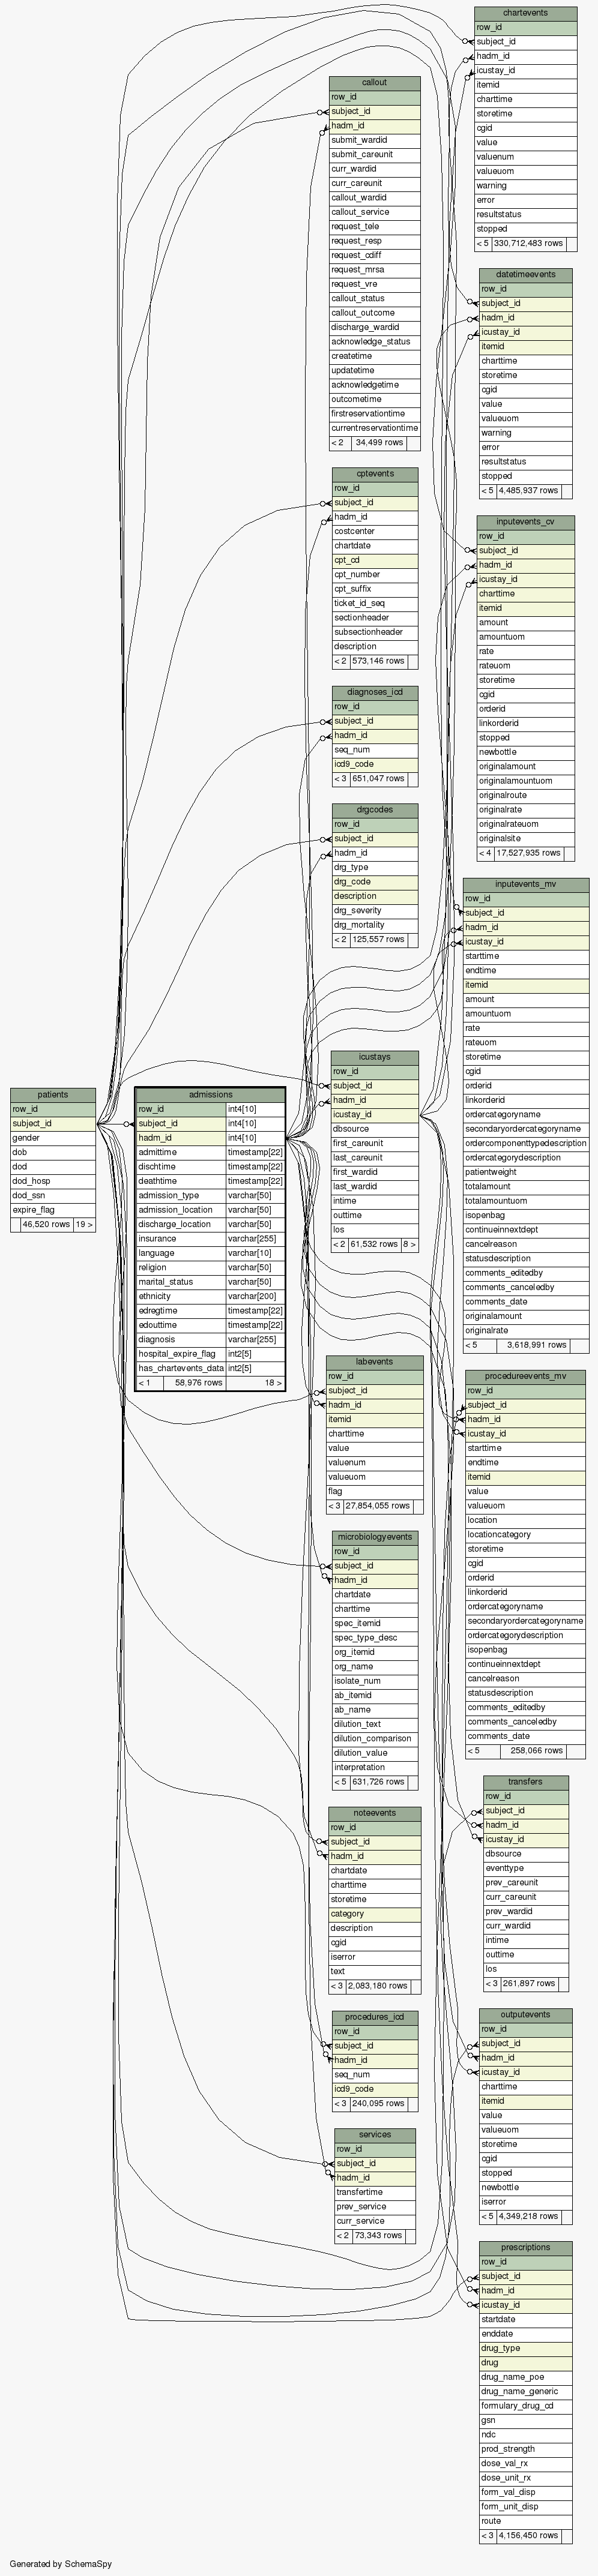

In [3]:
Image(filename = IMG_PATH + "admissions.1degree.png", width=1000, height=1000)

### 1. PATIENTS TABLE

In [5]:
mimic_patients_df = pd.read_csv(DATA_PATH + "mimic-III/PATIENTS.csv")
mimic_patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [14]:
# Total patients
print("Total patients: " + str(mimic_patients_df.GENDER.count()))

# Total from each gender
mimic_patients_df.GENDER.value_counts()

Total patients: 46520


M    26121
F    20399
Name: GENDER, dtype: int64

### 2. ADMISSIONS TABLE

In [7]:
mimic_admission_df = pd.read_csv(DATA_PATH + "mimic-III/ADMISSIONS.csv")
mimic_admission_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [7]:
# Total admissions
mimic_admission_df.count()

ROW_ID                  58976
SUBJECT_ID              58976
HADM_ID                 58976
ADMITTIME               58976
DISCHTIME               58976
DEATHTIME                5854
ADMISSION_TYPE          58976
ADMISSION_LOCATION      58976
DISCHARGE_LOCATION      58976
INSURANCE               58976
LANGUAGE                33644
RELIGION                58518
MARITAL_STATUS          48848
ETHNICITY               58976
EDREGTIME               30877
EDOUTTIME               30877
DIAGNOSIS               58951
HOSPITAL_EXPIRE_FLAG    58976
HAS_CHARTEVENTS_DATA    58976
dtype: int64

### MERGE: PATIENTS AND ADMSSIONS TABLE

In [104]:
ap = pd.merge(mimic_admission_df, mimic_patients_df, on = 'SUBJECT_ID' , how = 'inner')

### AGE CALCULATION

In [105]:
ages_df = ap #mimic_patients_df.merge(mimic_admission_df, on='SUBJECT_ID')

# ADMITTIME and DOB objects to datetime
ages_df["ADMITTIME"] = pd.to_datetime(ages_df["ADMITTIME"], format='%Y%m%d %H:%M:%S')
ages_df["DOB"] = pd.to_datetime(ages_df["DOB"], format='%Y%m%d %H:%M:%S')

In [106]:
ages_df["AGES"] = ages_df["ADMITTIME"].sub(ages_df["DOB"]).dt.days/365.242

# Adult patients only
ages_df = ages_df[(ages_df.AGES >= 15)]
print(ages_df.SUBJECT_ID.nunique())

# From each gender
patients_by_gender = ages_df.groupby('GENDER')['SUBJECT_ID'].nunique()
patients_by_gender

36654


GENDER
F    15476
M    21178
Name: SUBJECT_ID, dtype: int64

In [10]:
# Median age: total patients (non-unique)
ages_df['AGES'].mean()

62.46057714796226

In [11]:
# Standard deviation
ages_df['AGES'].std()

16.58856729669085

In [25]:
# Median age: by gender
median_age = ages_df.groupby('GENDER')['AGES'].mean()
median_age

GENDER
F    63.517513
M    61.670698
Name: AGES, dtype: float64

In [13]:
# Standard deviation
ages_df.groupby('GENDER')['AGES'].std()

GENDER
F    16.984218
M    16.242075
Name: AGES, dtype: float64

Text(0, 0.5, '# de pacientes')

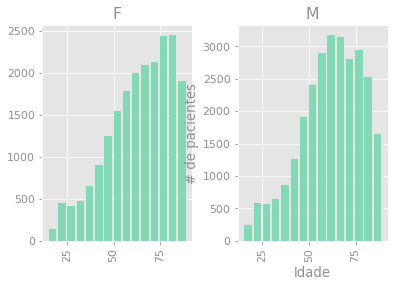

In [165]:
# Plots
ages_df.hist(column='AGES', by='GENDER', bins=15, color='#82d9b6', grid=False, zorder=2, rwidth=0.8)
plt.xlabel('Idade')
plt.ylabel('# de pacientes')

### INSURANCE

In [69]:
# Count unique non-NA observations
# insurance = mimic_admission_df.groupby('INSURANCE')['SUBJECT_ID'].nunique()

# Count non-NA observations
insurance = mimic_admission_df.groupby('INSURANCE')['SUBJECT_ID'].count()
insurance.sort_values(ascending=False)

INSURANCE
Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: SUBJECT_ID, dtype: int64

(-1.1180563215722998,
 1.1008598249032864,
 -1.1160806333608178,
 1.104134384643298)

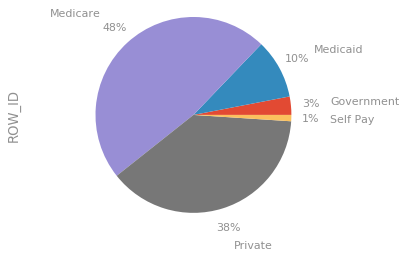

In [162]:
ins = mimic_admission_df.groupby(['INSURANCE']).count()['ROW_ID'].plot(kind='pie', autopct='%1.0f%%', 
                                                                       shadow=False, startangle=0, pctdistance=1.2, 
                                                                       labeldistance=1.4)
ins.axis('equal')
# ins.legend(frameon=False, bbox_to_anchor=(1.5, 0.8))

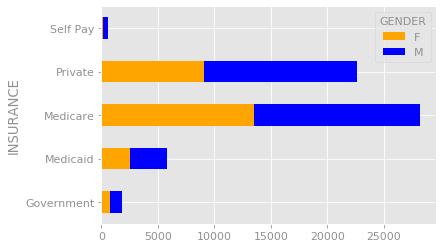

In [163]:
ap.groupby(['INSURANCE','GENDER']).size().unstack().plot(kind="barh", stacked=True, color=['orange', 'blue'])

In [ ]:
# Stacked bar plot with two-level groupby, percentages normalized to 100%

# ap.groupby(['INSURANCE','GENDER']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()
#                                                                 ).unstack().plot(kind='bar', stacked=True, 
#                                                                                  color=['orange', 'blue'])
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.show()

In [ ]:
# insurance by age

#### Medicare:

"*Medicare is a national health insurance program in the United States, begun in 1966 under the 
Social Security Administration (SSA) and now administered by the Centers for Medicare and Medicaid Services (CMS). 
It provides health insurance for Americans aged 65 and older, younger people with some disability status as 
determined by the Social Security Administration, as well as people with end stage renal disease and amyotrophic 
lateral sclerosis (ALS or Lou Gehrig's disease).*"

Source: https://en.wikipedia.org/wiki/Medicare_(United_States)

#### Medicaid:

"*Medicaid in the United States is a federal and state program that helps with medical costs for some people with 
limited income and resources. Medicaid also offers benefits not normally covered by Medicare, including nursing 
home care and personal care services. The Health Insurance Association of America describes Medicaid as 
"a government insurance program for persons of all ages whose income and resources are insufficient to pay for 
health care."*"

Source: https://en.wikipedia.org/wiki/Medicaid

### LANGUAGE

In [65]:
# Count unique non-NA observations
# language = mimic_admission_df.groupby(mimic_admission_df.LANGUAGE.str.strip("*"))['SUBJECT_ID'].nunique()

# Count non-NA observations
language = mimic_admission_df.groupby(mimic_admission_df.LANGUAGE.str.strip("*"))['SUBJECT_ID'].count()
language.sort_values(ascending=False)

LANGUAGE
ENGL    29086
SPAN     1083
RUSS      790
PTUN      628
CANT      413
PORT      342
CAPE      256
MAND      156
HAIT      150
ITAL      124
VIET       94
GREE       75
ARAB       47
PERS       44
CAMB       37
POLI       34
AMER       31
HIND       24
KORE       23
ALBA       17
FREN       16
SOMA       13
THAI       12
ETHI       11
ARM         9
BEN         7
GUJ         7
CHI         7
LAOT        7
HUN         7
        ...  
BENG        2
 BE         2
FUL         2
KHM         2
LEB         2
TURK        2
TOY         2
TOI         2
MOR         2
SH          2
BOS         1
 FU         1
 T          1
ARA         1
TAM         1
SPA         1
SERB        1
ROM         1
RUS         1
FIL         1
PUN         1
PHI         1
PER         1
NEP         1
LIT         1
CRE         1
DEA         1
GERM        1
FAR         1
YOR         1
Name: SUBJECT_ID, Length: 75, dtype: int64

There are 33644 admissions with language information (57% from total). English represents 65% of them.
Obs.: It's necessary to merge some of them due to the lack of pattern when answering this field.

In [16]:
# Amount of registered languages without merge
language.count()

75

### RELIGION

In [84]:
# Count unique non-NA observations
# religion = mimic_admission_df.groupby('RELIGION')['SUBJECT_ID'].nunique()

# Count non-NA observations
religion = mimic_admission_df.groupby('RELIGION')['SUBJECT_ID'].count()
religion.sort_values(ascending=False)

RELIGION
CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: SUBJECT_ID, dtype: int64

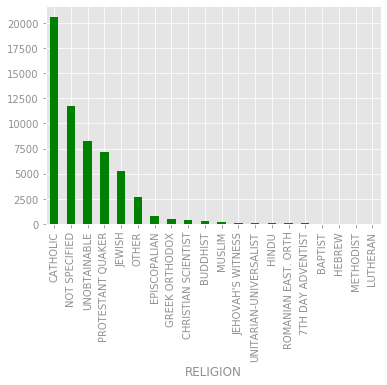

In [136]:
rel = mimic_admission_df.groupby(['RELIGION']).count()['ROW_ID']
rel.sort_values(ascending=False).plot(kind = 'bar', color='green')

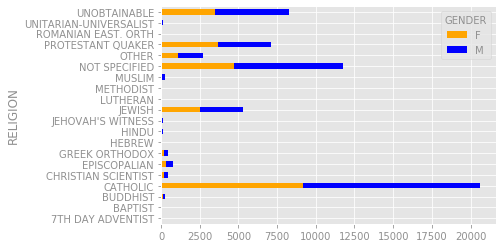

In [158]:
ap.groupby(['RELIGION','GENDER']).size().unstack().plot(kind="barh", stacked=True, color=['orange', 'blue'])

### MARITAL STATUS

In [85]:
# Count unique non-NA observations
# marital_st = mimic_admission_df.groupby('MARITAL_STATUS')['SUBJECT_ID'].nunique()

# Count non-NA observations
marital_st = mimic_admission_df.groupby('MARITAL_STATUS')['SUBJECT_ID'].count()
marital_st.sort_values(ascending=False)

MARITAL_STATUS
MARRIED              24239
SINGLE               13254
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      345
LIFE PARTNER            15
Name: SUBJECT_ID, dtype: int64

(-1.1264467775433058,
 1.1012594015637784,
 -1.1114479600723297,
 1.1285369970250627)

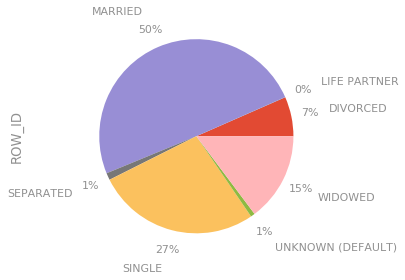

In [103]:
mar = mimic_admission_df.groupby(['MARITAL_STATUS']).count()['ROW_ID'].plot(kind='pie', autopct='%1.0f%%', 
                                                                      shadow=False, startangle=0, pctdistance=1.2, 
                                                                      labeldistance=1.4)
mar.axis('equal')
# mar.legend(frameon=False, bbox_to_anchor=(1.8, 0.8))

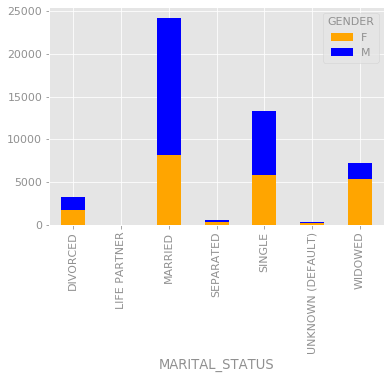

In [164]:
ap.groupby(['MARITAL_STATUS','GENDER']).size().unstack().plot(kind="bar", stacked=True, color=['orange', 'blue'])

### ETHNICITY

In [88]:
# Count unique non-NA observations
# ethnicity = mimic_admission_df.groupby('ETHNICITY')['SUBJECT_ID'].nunique()

# Count unique non-NA observations
ethnicity = mimic_admission_df.groupby('ETHNICITY')['SUBJECT_ID'].count()
ethnicity

ETHNICITY
AMERICAN INDIAN/ALASKA NATIVE                                  51
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE        3
ASIAN                                                        1509
ASIAN - ASIAN INDIAN                                           85
ASIAN - CAMBODIAN                                              17
ASIAN - CHINESE                                               277
ASIAN - FILIPINO                                               25
ASIAN - JAPANESE                                                7
ASIAN - KOREAN                                                 13
ASIAN - OTHER                                                  17
ASIAN - THAI                                                    4
ASIAN - VIETNAMESE                                             53
BLACK/AFRICAN                                                  44
BLACK/AFRICAN AMERICAN                                       5440
BLACK/CAPE VERDEAN                                            200


In [89]:
ethinicity_dict = ethnicity.to_dict()

sum_white = sum([value for key, value in ethinicity_dict.items() if 'WHITE' in key])
print("WHITE: " + str(sum_white))
sum_black = sum([value for key, value in ethinicity_dict.items() if 'BLACK' in key])
print("BLACK: " + str(sum_black))
sum_asian = sum([value for key, value in ethinicity_dict.items() if 'ASIAN' in key])
print("ASIAN: " + str(sum_asian))
sum_latino = sum([value for key, value in ethinicity_dict.items() if 'LATINO' in key])
print("LATINO: " + str(sum_latino))
print("OTHER: 1512\nUNKNOWN/NOT SPECIFIED: 4523")

WHITE: 41325
BLACK: 5785
ASIAN: 2007
LATINO: 2128
OTHER: 1512
UNKNOWN/NOT SPECIFIED: 4523


There were 41325 admissions from white people. This represents 70% from total. Blacks represent only 9,8%, followed by unknown (7,7%), asians and latinos (~3,5%).

In [90]:
# Select
mimic_admission_df.loc[(mimic_admission_df['SUBJECT_ID'] == 109) & (mimic_admission_df['HADM_ID'] == 172335)]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
172,128,109,172335,2141-09-18 10:32:00,2141-09-24 13:53:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,ENGL,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,2141-09-18 07:06:00,2141-09-18 11:25:00,LEG PAIN,0,1


### 3. DIAGNOSES AND ICD9 CODES TABLES

ICD-9 codes corresponding to the diagnosis assigned to the patient for the given row.

In [91]:
mimic_diagnoses_df = pd.read_csv(DATA_PATH + "mimic-III/DIAGNOSES_ICD.csv")
mimic_diagnoses_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [92]:
mimic_diagnoses_descriptions_df = pd.read_csv(DATA_PATH + "mimic-III/D_ICD_DIAGNOSES.csv")
mimic_diagnoses_descriptions_df.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [93]:
diagnoses_icd9_count_dict = mimic_diagnoses_df['ICD9_CODE'].value_counts().to_dict()

diagnoses_icd9_count_dict2 = {}
for k, v in diagnoses_icd9_count_dict.items():
    row = mimic_diagnoses_descriptions_df.loc[(mimic_diagnoses_descriptions_df['ICD9_CODE'] == k)]
    diagnose_description = row.get('LONG_TITLE').to_list()
    if diagnose_description:
        diagnoses_icd9_count_dict2[diagnose_description[0]] = v
    else: 
        diagnoses_icd9_count_dict2[k] = v

# Diagnoses ordered by most common to least common
diagnoses_icd9_count_dict2

{'Unspecified essential hypertension': 20703,
 'Congestive heart failure, unspecified': 13111,
 'Atrial fibrillation': 12891,
 'Coronary atherosclerosis of native coronary artery': 12429,
 'Acute kidney failure, unspecified': 9119,
 'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled': 9058,
 'Other and unspecified hyperlipidemia': 8690,
 'Acute respiratory failure': 7497,
 'Urinary tract infection, site not specified': 6555,
 'Esophageal reflux': 6326,
 'Pure hypercholesterolemia': 5930,
 'Need for prophylactic vaccination and inoculation against viral hepatitis': 5779,
 'Observation for suspected infectious condition': 5519,
 'Anemia, unspecified': 5406,
 'Unspecified acquired hypothyroidism': 4917,
 'Pneumonia, organism unspecified': 4839,
 'Acute posthemorrhagic anemia': 4552,
 'Acidosis': 4528,
 'Chronic airway obstruction, not elsewhere classified': 4431,
 'Severe sepsis': 3912,
 'Long-term (current) use of anticoagulants': 

In [94]:
diagnoses_icd9_df = pd.DataFrame(list(diagnoses_icd9_count_dict2.items()), columns=['DIAGNOSES', 'PATIENTS'])
diagnoses_icd9_df.head()

,DIAGNOSES,PATIENTS
0,Unspecified essential hypertension,20703
1,"Congestive heart failure, unspecified",13111
2,Atrial fibrillation,12891
3,Coronary atherosclerosis of native coronary ar...,12429
4,"Acute kidney failure, unspecified",9119


### 4. ICUSTAYS TABLE

In [95]:
mimic_icustays_df = pd.read_csv(DATA_PATH + "mimic-III/ICUSTAYS.csv")
mimic_icustays_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [96]:
mimic_icustays_df.groupby('FIRST_CAREUNIT')['SUBJECT_ID'].nunique()

FIRST_CAREUNIT
CCU       6802
CSRU      8424
MICU     15636
NICU      7870
SICU      7695
TSICU     6027
Name: SUBJECT_ID, dtype: int64